In [ ]:
import matplotlib.pyplot as plt

from pdeep.mhc.mhc_binding_model import *
from pdeep.mhc.plotting_utils import *
from pdeep.mhc.mhc_utils import *
from pdeep.mhc.mhc_binding_retriever import MHCBindingRetriever

hla_model_pt = "HLA_model_v0613.pt"
pept_model_pt = "pept_model_v0613.pt"

pept_encoder = ModelSeqEncoder().to("cuda")
hla_encoder = ModelHlaEncoder().to("cuda")
hla_encoder.load_state_dict(torch.load(f"model/{hla_model_pt}", map_location="cuda"))
pept_encoder.load_state_dict(torch.load(f"model/{pept_model_pt}", map_location="cuda"))

fasta_list = ["uniprotkb_UP000005640_AND_reviewed_true_2024_03_01.fasta"]

In [2]:
with open(f"embeds/{hla_model_pt}.embed", "rb") as f:
    data_dict = pickle.load(f)
    hla_df = data_dict["protein_df"]
    hla_embeds = data_dict["embeds"]
    umap_reducer = data_dict["umap_reducer"]

retriever = MHCBindingRetriever(
    hla_encoder, pept_encoder, hla_df, hla_embeds,
    fasta_list
)

In [3]:
known_alele_df = pd.read_table("known_allele_list.txt", index_col=False)
known_alele_df

,allele
0,B07_02
1,B07_04
2,B07_06
3,B35_02
4,B35_03
...,...
136,B08_03
137,B48_01
138,C06_02
139,C07_01


In [4]:
test_hla_df = hla_df[hla_df["allele"].isin(known_alele_df["allele"].tolist())]
test_hla_df = test_hla_df.drop_duplicates("allele")
test_hla_embeds = hla_embeds[test_hla_df.index.values]

In [5]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

cut_height = 0.5
Z = linkage(test_hla_embeds, 'complete')
clusters = fcluster(Z, cut_height, criterion='distance')
clusters

array([ 7, 10,  5,  2, 12,  9,  7,  7, 17, 18,  7,  7,  7, 18, 18,  6,  6,
       18,  6,  6,  6,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 13, 13, 13,
       13,  9,  9, 16, 16, 16, 16, 16,  9,  7,  7,  9, 18, 11, 11,  5,  5,
       12,  4,  4,  5,  4,  4,  4,  4,  1,  1,  1,  1,  1,  1, 10, 10, 12,
       14, 12, 13, 13, 14, 14, 16, 16, 16, 16, 16, 14, 10, 16, 10, 14, 10,
       16, 16,  1,  1,  1,  1,  2,  3,  3,  3,  5,  5,  5,  2, 15,  3,  3,
        3,  8,  8,  2,  2,  2,  2,  2,  2, 18,  3, 16, 17, 17, 16, 16, 18,
        4,  4,  4, 17, 17, 17, 17,  8, 15,  1,  1,  1,  1, 15, 15, 15, 14,
       14, 14, 11,  9,  2], dtype=int32)

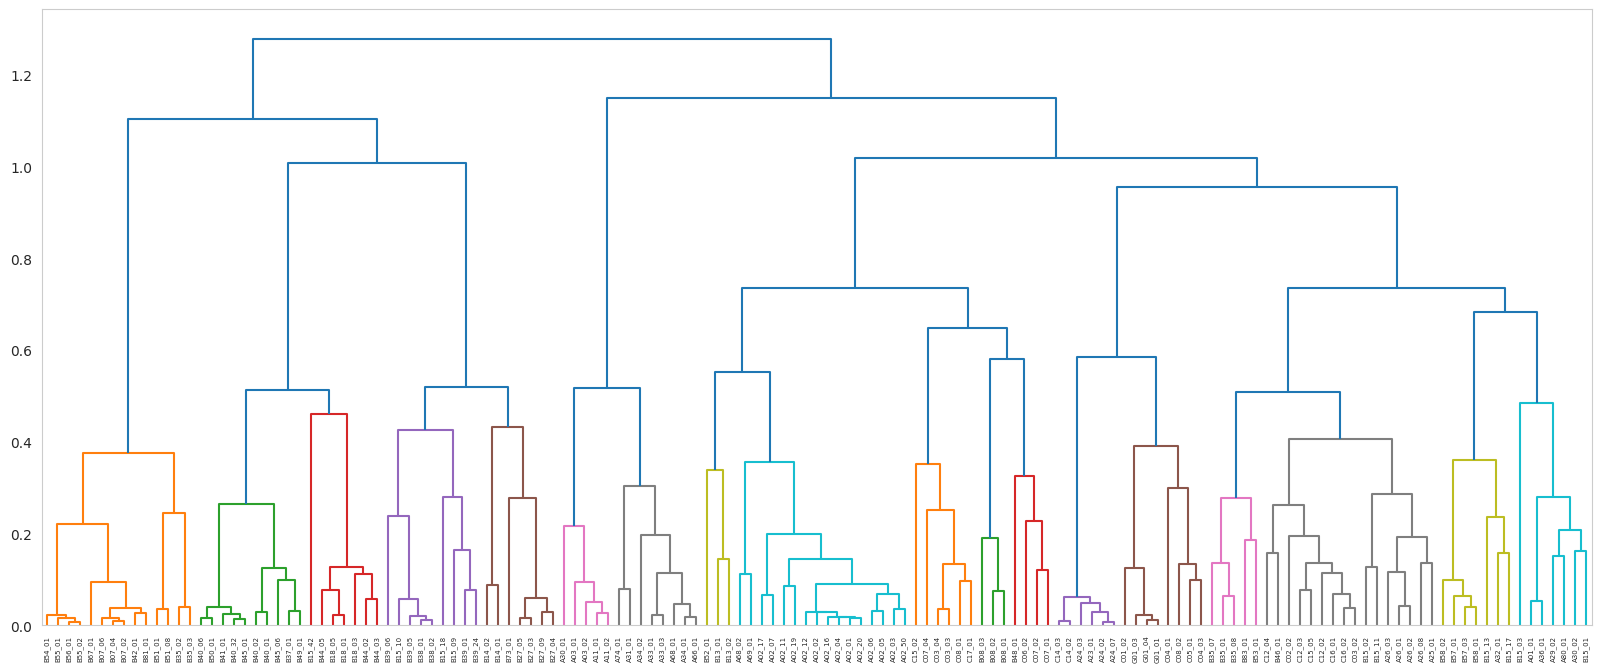

In [6]:
plt.figure(figsize=(20, 8))
tree = dendrogram(Z, color_threshold=cut_height, labels=test_hla_df["allele"].values)
plt.grid(False)
plt.show()

In [7]:
import copy

leaf_indices = tree["leaves"]
reordered_alleles = [test_hla_df.allele.values[i] for i in leaf_indices]
reordered_hla_embeds = copy.deepcopy(test_hla_embeds[leaf_indices, :])

ret_dists_matrix = retriever.get_embedding_distances(reordered_hla_embeds, reordered_hla_embeds)

In [8]:
a_list = []
b_list = []
dists_list = []
sizes_list = []
for i in range(len(reordered_alleles)):
    for k in range(len(reordered_alleles)):
        a_list.append(reordered_alleles[i])
        b_list.append(reordered_alleles[k])
        tmp_dist = int(ret_dists_matrix[i,k]*1000)/1000
        dists_list.append(tmp_dist)
        sizes_list.append(2-tmp_dist)

dist_df = pd.DataFrame(
    {
        "allele1":a_list,
        "allele2":b_list,
        "distance":dists_list,
        "size":sizes_list
    }
)
dist_df

,allele1,allele2,distance,size
0,B54_01,B54_01,0.000,2.000
1,B54_01,B55_01,0.022,1.978
2,B54_01,B56_01,0.017,1.983
3,B54_01,B55_02,0.012,1.988
4,B54_01,B67_01,0.220,1.780
...,...,...,...,...
19876,B15_01,A36_01,0.279,1.721
19877,B15_01,A29_02,0.208,1.792
19878,B15_01,A80_01,0.187,1.813
19879,B15_01,A30_02,0.162,1.838


In [9]:
from matplotlib.colors import LinearSegmentedColormap

custom_colors = [(0.0, '#00008B'), (1.0, 'white')]
custom_cmap = LinearSegmentedColormap.from_list("CustomMap", custom_colors)

<Figure size 9000x6000 with 0 Axes>

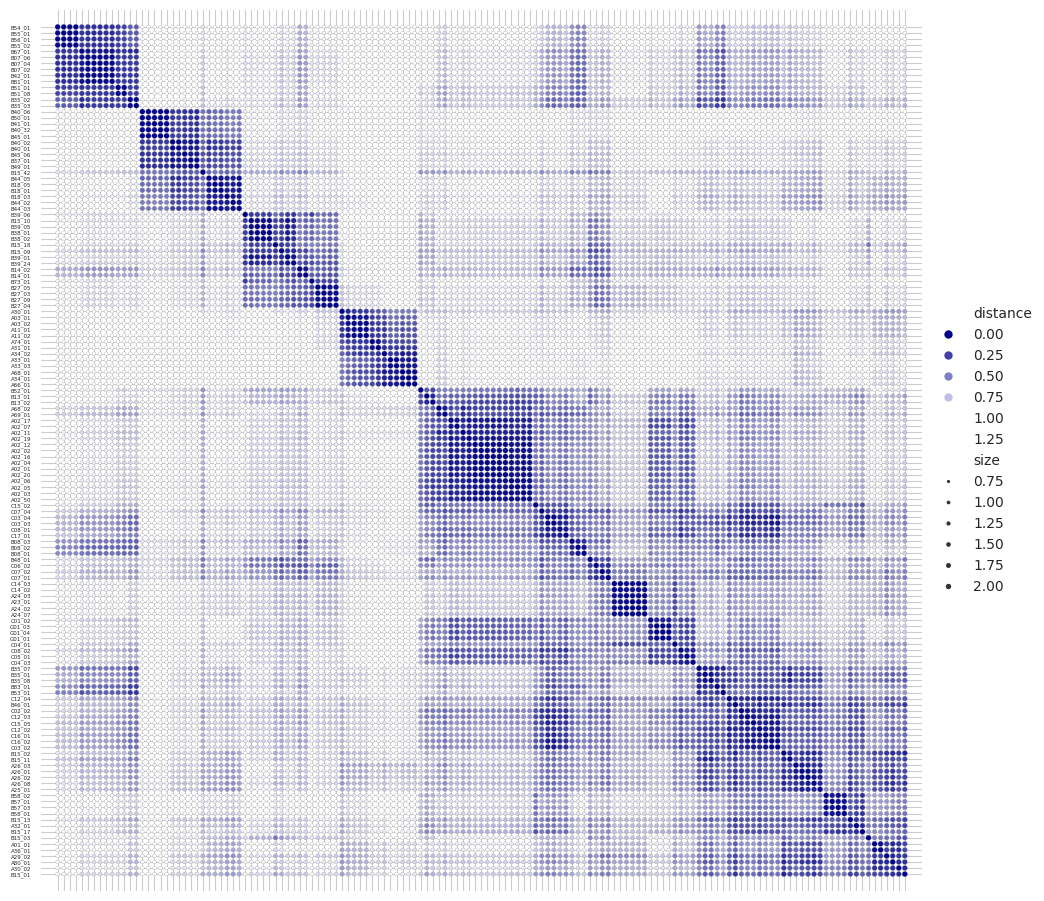

In [10]:
import seaborn as sns

plt.figure(figsize=(30,20), dpi=300)

g = sns.relplot(
    data=dist_df,
    x="allele1", y="allele2", hue="distance", size="size",
    palette=custom_cmap, hue_norm=(0, 1), edgecolor=".6",
    height=10, sizes=(5,15),legend="brief"
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.yaxis.set_tick_params(labelsize=4)
g.ax.margins(.02)
g.ax.xaxis.set_ticks_position('none')
g.ax.xaxis.set_ticklabels([])

plt.show()